In [1]:
import os

from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
token = os.getenv('HF_TOKEN')
login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
!wandb login ${WANDB_KEY}

import seaborn as sns

import torch

# Configuração do Matplotlib e Seaborn
%matplotlib inline
sns.set_theme(style='darkgrid')

wandb: Currently logged in as: axdber (axdber-pers). Use `wandb login --relogin` to force relogin


In [4]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sentiment140", trust_remote_code=True)


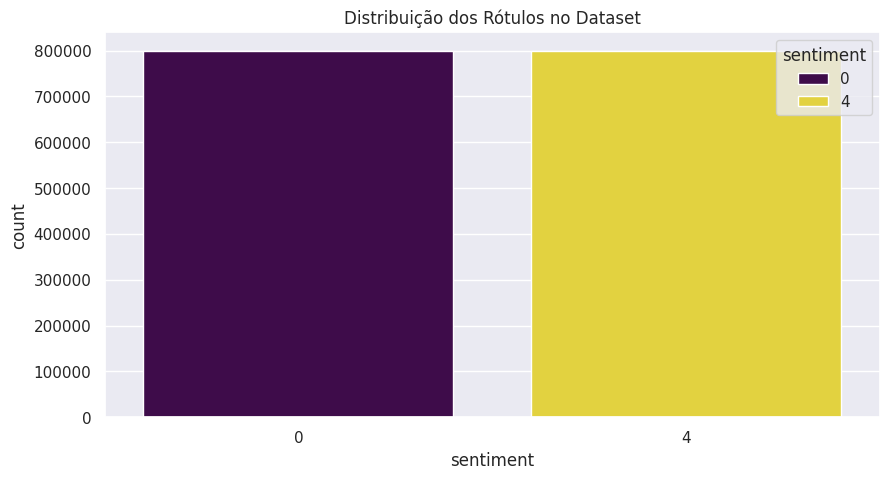

In [ ]:


# # Visualizando a distribuição dos rótulos
# plt.figure(figsize=(10, 5))
# sns.countplot(x='sentiment', data=df_train, palette='viridis', hue='sentiment', legend=True)
# plt.title('Distribuição dos Rótulos no Dataset')
# plt.show()

In [5]:
# Carregar o tokenizador BERT
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize_text(examples):
    tokenized_batch = tokenizer(examples["text"], padding="max_length", truncation=True)
    # Add labels
    transformed_labels = [label // 2 for label in examples["sentiment"]]
    tokenized_batch["labels"] = torch.tensor(transformed_labels)
    # Or handle it in another appropriate way
    return tokenized_batch


def load_tokenized_data(name, file_path, num_proc=4, reduction_factor=0.1):
    if os.path.exists(file_path):
        return torch.load(file_path)
    else:
        tokenized_ds = (
            dataset[name]
            .shuffle(seed=42)
            .select(range(int(len(dataset[name]) * reduction_factor)))
            .map(
                tokenize_text,
                batched=True,
                num_proc=num_proc,  # Parallelize with specified number of processes
            )
        )
        torch.save(tokenized_ds, file_path)
        return tokenized_ds


tokenized_train = load_tokenized_data("train", "tokenized_train.pt")
tokenized_test = load_tokenized_data("test", "tokenized_test.pt")
# Tokenizing the text data


Map (num_proc=4):   0%|          | 0/160000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/49 [00:00<?, ? examples/s]

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

model = DistilBertForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=3)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
# Definir argumentos de treinamento
training_args = TrainingArguments(
    output_dir='./results',          # Pasta de saída
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    learning_rate=2e-5,              # Taxa de aprendizado
    per_device_train_batch_size=8,  # Tamanho do lote de treinamento
    per_device_eval_batch_size=8,   # Tamanho do lote de avaliação
    num_train_epochs=2,              # Número de épocas de treinamento
    save_steps=2,
    save_total_limit=2,
    weight_decay=0.01,               # Decaimento do peso
    logging_dir='./logs',  # Directory for storing logs
    # label_names=[0,1,2],
    # fp16=True,
    # load_best_model_at_end = True
)

# Definir o treinador
trainer = Trainer(
    model=model,                        # O modelo a ser treinado
    args=training_args,                 # Argumentos de treinamento
    train_dataset=tokenized_train,      # Dataset de treinamento
    eval_dataset=tokenized_test,        # Dataset de avaliação
    compute_metrics=compute_metrics,           # Function to compute metrics during evaluation

    # callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: axdber (axdber-pers). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Evaluate the model
eval_result = trainer.evaluate()
print(eval_result)
# Predictions and metrics calculation
predictions, label_ids, _ = trainer.predict(tokenized_test)
predictions = torch.argmax(torch.tensor(predictions), dim=1)  # Get the predicted classes

# Calculate metrics
accuracy = accuracy_score(label_ids, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(label_ids, predictions, average='weighted')

# Print metrics
print(f"Avaliação do Modelo: {eval_result}")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão (precision): {precision:.2f}")
print(f"Revocação (recall): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")